# SFR
streamflow routing 6 example using created already created grid and shapefile

In [1]:
import flopy
import numpy as np
from sfrmaker import Lines, UnstructuredGrid
import geopandas as gpd
import pandas as pd

flopy is installed in C:\thomas\Anaconda3\lib\site-packages\flopy


In [3]:
# initiate new model needed for sfrmaker to work
mdl = flopy.modflow.Modflow(model_ws='sim/kou')

# read created imod unstructed grid
grd_gdf = gpd.read_file('data/kou/kou02qtg.shp')
grd_gdf['node'] = grd_gdf['nodenumber']
grd_gdf['isfr'] = 1
grd = UnstructuredGrid.from_dataframe(grd_gdf, model_units='meters', epsg=32630)

# return general grid information
grd

C:\thomas\Anaconda3\lib\site-packages\pyproj\crs.py:422: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  projstring = _prepare_from_string(projparams)


Model grid information
unstructured grid
nnodes: 8,157
model length units: meters
crs: +init=epsg:32630 +no_defs
bounds: 228000.00, 1113000.00, 578000.00, 1413000.00
active area defined by: all cells

In [4]:
# load the kou river, added some columns, see below, first one segment id (cannot contain 0), 
# downstream segment, upstream width of the segment, downstream width of the segment,
# upstream elevation of segment (not sure if this is bed level), downstream elevation of segment
# bedlevel can also be determined from dem, see somewhere below
kou = gpd.read_file('data/kou/Kou_UTM.shp')
lns = Lines.from_dataframe(kou, id_column='id', routing_column='down', width1_column='width_st', 
                           width2_column='width_end', up_elevation_column='height_st', 
                           dn_elevation_column='height_end', epsg=32630)

C:\thomas\Anaconda3\lib\site-packages\pyproj\crs.py:422: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  projstring = _prepare_from_string(projparams)


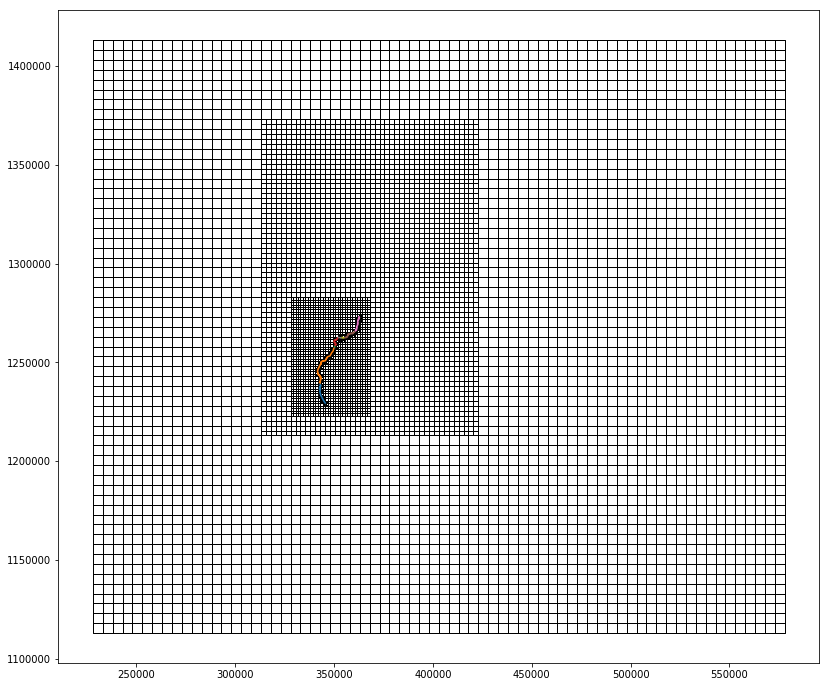

In [5]:
# plot of grid & river, color is segments of the shapefile
ax = grd_gdf.plot(facecolor='none', figsize=(15,12), edgecolor='k')
kou.plot(ax=ax, column='OSM_ID');

In [6]:
# initiate sfr (stream flow routing) dataset, based on the river segments and the grid
sfr = lns.to_sfr(grid=grd, model=mdl)


SFRmaker version 0.2.1

Creating sfr dataset...
Model grid information
unstructured grid
nnodes: 8,157
model length units: meters
crs: +init=epsg:32630 +no_defs
bounds: 228000.00, 1113000.00, 578000.00, 1413000.00
active area defined by: all cells


Culling hydrography to active area...
starting lines: 9
remaining lines: 9
finished in 0.01s


Intersecting 9 flowlines with 8,157 grid cells...
Intersecting 9 features...
8

C:\thomas\Anaconda3\lib\site-packages\pyproj\crs.py:422: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  projstring = _prepare_from_string(projparams)
C:\thomas\Anaconda3\lib\site-packages\pyproj\crs.py:422: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  projstring = _prepare_from_string(projparams)
C:\thomas\Anaconda3\lib\site-packages\pyproj\crs.py:422: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  projstring = _prepare_from_string(projparams)
C:\thomas\Anaconda3\lib\site-packages\pyproj\crs.py:422: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  projstring = _prepare_from_string(projparams)
C:\thomas\Anaconda3\lib\site-packages\pyproj\crs.py:422: FutureWarning: '+init=<

9
finished in 0.22s

Setting up reach data... (may take a few minutes for large grids)
finished in 0.28s


Dropping 11 reaches with length < 15.62 meters...

Repairing routing connections...
enforcing best segment numbering...

Setting up segment data...
Model grid information
unstructured grid
nnodes: 8,157
model length units: meters
crs: +init=epsg:32630 +no_defs
bounds: 228000.00, 1113000.00, 578000.00, 1413000.00
active area defined by: all cells


Time to create sfr dataset: 0.72s



In [7]:
# load the dem (digital elevation model), 90x90 meters & sample elevations for each segment, this takes a while... (~30 minutes)
dem = 'data/kou/n10w5_dem_utm.asc'
sfr.set_streambed_top_elevations_from_dem(dem, dem_z_units='meters', method='buffers', smooth=True)

C:\thomas\Anaconda3\lib\site-packages\pyproj\crs.py:422: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  projstring = _prepare_from_string(projparams)
C:\thomas\Anaconda3\lib\site-packages\pyproj\crs.py:422: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  projstring = _prepare_from_string(projparams)


running rasterstats.zonal_stats on buffered LineStrings...


KeyboardInterrupt: 

In [8]:
# run flopy diagnostics
sfr.create_modflow_sfr2(model=mdl)
sfr.modflow_sfr2.check()

****Warning -- two packages of the same type:  <class 'flopy.modflow.mfsfr2.ModflowSfr2'> <class 'flopy.modflow.mfsfr2.ModflowSfr2'>
replacing existing Package...
passed.

Checking for continuity in segment and reach numbering...
passed.

Checking for increasing segment numbers in downstream direction...
passed.

Checking for circular routing...
passed.

No DIS package or SpatialReference object; cannot check reach proximities.

Checking for model cells with multiple non-zero SFR conductances...
1 model cells with multiple non-zero SFR conductances found.
This may lead to circular routing between collocated reaches.
Nodes with overlapping conductances:
k	i	j	iseg	ireach	rchlen	strthick	strhc1
0	0	0	1	1	168.87303161621094	1.0	1.0
0	0	0	1	2	298.3865966796875	1.0	1.0
0	0	0	1	3	170.69644165039062	1.0	1.0
0	0	0	1	4	365.9299621582031	1.0	1.0
0	0	0	1	5	26.219375610351562	1.0	1.0
0	0	0	1	6	398.63037109375	1.0	1.0
0	0	0	1	7	182.2174835205078	1.0	1.0
0	0	0	1	8	182.3929901123047	1.0	1.0
0	0	0	1	9

In [9]:
# write the package
sfr.write_package('output/kou/example.sfr')

****Warning -- two packages of the same type:  <class 'flopy.modflow.mfsfr2.ModflowSfr2'> <class 'flopy.modflow.mfsfr2.ModflowSfr2'>
replacing existing Package...


In [10]:
sfr.export_cells('output/kou/example_cells.shp')
sfr.export_outlets('output/kou/example_outlets.shp')
sfr.export_lines('output/kou/example_lines.shp')
sfr.export_routing('output/kou/example_routing.shp')

writing output/kou/example_cells.shp...
writing output/kou/example_outlets.shp...
writing output/kou/example_lines.shp...
writing output/kou/example_routing.shp...
